In [42]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import matplotlib.pyplot as plt

import sklearn
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV

from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [136]:
##LOAD TRAINING DATAFRAME

# categorical variable train dataframe

file_path_trainC = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx"
train_cat = pd.read_excel(file_path_trainC)

# Functional Connectome Matrices

file_path_trainFCM = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv"
train_FCM = pd.read_csv(file_path_trainFCM)

# Quantitative varaible train dataframe

file_path_trainQ = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx"
train_Quant = pd.read_excel(file_path_trainQ)

# ADHD and Sex solutions dataframe for model training

file_path_trainS = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx"
train_Solutions = pd.read_excel(file_path_trainS)

In [137]:
##LOAD TEST DATAFRAME

# categorical variable test dataframe

file_path_testC = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx"
test_cat = pd.read_excel(file_path_testC)

# Functional Connectome Matrices

file_path_testFCM = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv"
test_FCM = pd.read_csv(file_path_testFCM)

# Quantitative varaible test dataframe

file_path_testQ = "C:/Users/sitif/Downloads/WIDS/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx"
test_Quant = pd.read_excel(file_path_testQ)

In [138]:
train_FCM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Columns: 19901 entries, participant_id to 198throw_199thcolumn
dtypes: float64(19900), object(1)
memory usage: 184.2+ MB


In [139]:
test_FCM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Columns: 19901 entries, participant_id to 198throw_199thcolumn
dtypes: float64(19900), object(1)
memory usage: 46.2+ MB


In [98]:
test_FCM.dtypes

participant_id           object
0throw_1thcolumn        float64
0throw_2thcolumn        float64
0throw_3thcolumn        float64
0throw_4thcolumn        float64
                         ...   
196throw_199thcolumn    float64
197throw_198thcolumn    float64
197throw_199thcolumn    float64
198throw_199thcolumn    float64
max_activity_region      object
Length: 19902, dtype: object

In [143]:
train_FCM.dtypes

participant_id           object
0throw_1thcolumn        float64
0throw_2thcolumn        float64
0throw_3thcolumn        float64
0throw_4thcolumn        float64
                         ...   
196throw_198thcolumn    float64
196throw_199thcolumn    float64
197throw_198thcolumn    float64
197throw_199thcolumn    float64
198throw_199thcolumn    float64
Length: 19901, dtype: object

In [152]:
#Identify which region has the most activity (train)
train_FCM['max_activity_region'] = train_FCM.iloc[:, 1:1990].idxmax(axis=1)
train_FCM['max_activity_value'] = train_FCM.iloc[:, 1:1990].max(axis=1)
train_FCM_max = train_FCM[['participant_id','max_activity_region','max_activity_value']]
train_FCM_max.head()

,participant_id,max_activity_region,max_activity_value
0,70z8Q2xdTXM3,1throw_103thcolumn,0.314661
1,WHWymJu6zNZi,7throw_9thcolumn,0.215325
2,4PAQp1M6EyAo,1throw_103thcolumn,0.288996
3,obEacy4Of68I,2throw_102thcolumn,0.227515
4,s7WzzDcmDOhF,1throw_3thcolumn,0.236001


max_activity_region
1throw_103thcolumn    436
2throw_102thcolumn    131
3throw_103thcolumn    115
1throw_3thcolumn      109
8throw_107thcolumn     74
                     ... 
5throw_196thcolumn      1
1throw_100thcolumn      1
8throw_10thcolumn       1
10throw_11thcolumn      1
8throw_22thcolumn       1
Name: count, Length: 84, dtype: int64


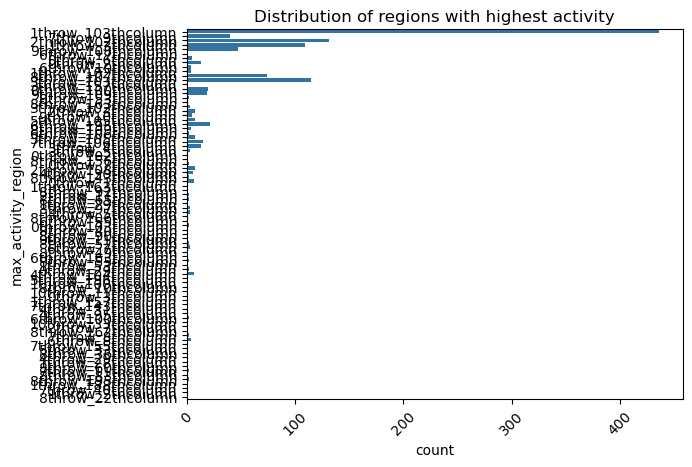

In [168]:
#Distibution of region with highest activity(train)
max_activity_region_counts = train_FCM_max['max_activity_region'].value_counts()
print(max_activity_region_counts)

sns.countplot(y ='max_activity_region', data= train_FCM_max[['max_activity_region']])
plt.title(f"Distribution of regions with highest activity")
plt.xticks(rotation=45)
plt.show()

In [132]:
test_FCM_max_sorted = test_FCM_max.sort_values(by='max_activity_value', ascending=False)
print(test_FCM_max_sorted)

    participant_id max_activity_region  max_activity_value
253   6mGSjnkluhCm  7throw_168thcolumn            0.976611
124   7v5DsWe80ek1  9throw_108thcolumn            0.946676
133   sdJvoGXQsxzG  9throw_108thcolumn            0.938783
27    yYjiJsx8PM48  9throw_108thcolumn            0.932726
123   LsErFKyD0Amx  9throw_108thcolumn            0.931481
..             ...                 ...                 ...
240   KK1MoDOaknzz   9throw_10thcolumn            0.747599
288   8EcGmW8AXSPl  9throw_109thcolumn            0.747245
8     uM4etVLZrgMg    1throw_2thcolumn            0.743000
122   mca5wy8JcazG  2throw_102thcolumn            0.738521
126   Wm8vHtUOTSdK  8throw_107thcolumn            0.721784

[304 rows x 3 columns]
